In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

tf.set_random_seed(1)
np.random.seed(1)

# Input data

In [2]:
from data_utils import train_cnn_input_fn, test_cnn_input_fn

In [3]:
class_nbr = 6
batch_size = 2

In [4]:
train_input_fn = lambda: train_cnn_input_fn(class_nbr, "../tmp/cnn_output/VGG16", batch_size, keep_fn=False)
test_input_fn = lambda: test_cnn_input_fn(class_nbr, "../tmp/cnn_output/VGG16", batch_size, keep_fn=False)

In [41]:
# Make sure it works
with tf.Session() as sess: 
    print(sess.run(train_input_fn()))
    print(sess.run(test_input_fn()))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [45]:
test_csv_path = os.path.join('..', 'data/DAGM 2007 - Splitted', str(class_nbr), 'test_files.csv')
df = pd.read_csv(test_csv_path, sep=",")
df.head()

,Unnamed: 0,original_path,is_healthy,target
0,0,data\957.png,1,test\001.png
1,1,def\87.png,-1,test\002.png
2,2,data\180.png,1,test\003.png
3,3,def\122.png,-1,test\004.png
4,4,data\12.png,1,test\005.png


In [46]:
def csv_generator(csv_path, class_nbr, keep_fn=False):
    df = pd.read_csv(csv_path, sep=",")
    for index, row in df.iterrows():
        img_path = os.path.join('..', 'data/DAGM 2007 - Splitted', str(class_nbr), row['target'].replace("\\", "/"))
        img_fn = os.path.basename(img_path)
        img_encoded = np.load("../tmp/cnn_output/VGG16/{}/{}.npy".format(
            class_nbr,
            row['target'].replace("\\", "/")
        ))
        label = row['is_healthy']
        if keep_fn:
            yield (img_fn, img_encoded, label)
        yield (img_encoded, label)

def eval_input_fn(eval_csv_path=eval_csv_path, target_width=224, batch_size=2):
    dataset = tf.data.Dataset.from_generator(
        generator=lambda: csv_generator(eval_csv_path, 6),
        output_types=(tf.float32, tf.int32)
    )
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

eval_input_fn(test_csv_path)

(<tf.Tensor 'IteratorGetNext_8:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'IteratorGetNext_8:1' shape=<unknown> dtype=int32>)

In [59]:
y_true = []
input_fn = eval_input_fn(test_csv_path, batch_size=1)
sess = tf.Session()
while True:
    try:
        y_true.append(sess.run(input_fn)[1])
    except tf.errors.OutOfRangeError:
        break
y_true = np.asarray(y_true).flatten()
y_true.shape

(300,)

# Naive SVDD estimator

In [6]:
from estimator_svdd_naive import naive_svdd_model_fn

In [28]:
n_inputs = 850
train_steps = 10
model_dir = "../tmp/estimator_svdd_naive"

In [71]:
OCClassifier = tf.estimator.Estimator(
    model_fn=naive_svdd_model_fn,
    params={
        "frac_err": 50,
        "n_inputs": n_inputs,
        "kernel": "linear",
        "rffm_dims": 200,
        "rffm_stddev": 25,
        "learning_rate": 0.1,
        "input_size": 25088
    },
    model_dir=model_dir
)

predictions = OCClassifier.predict(
    input_fn=test_input_fn
)
predictions_list = list(predictions)
predictions_distance = np.asarray(list(map(lambda p: p["predicted_distance"], predictions_list)))
predictions_classes = np.asarray(list(map(lambda p: p["predicted_classes"], predictions_list))).astype(np.int32)
mapped_inputs = np.asarray(list(map(lambda p: p["mapped_inputs"], predictions_list)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../tmp/estimator_svdd_naive', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1199cce80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../tmp/estimator_svdd_naive/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Sklearn OCSVM

In [89]:
# Must load full data in memory with sklearn

# Train set
x_train = []
input_fn = train_input_fn()
sess = tf.Session()
while True:
    try:
        data = sess.run(input_fn)
        for i in range(batch_size):
            x_train.append(data[i])
    except tf.errors.OutOfRangeError:
        break
x_train = np.asarray(x_train)

# Test set
x_test = []
input_fn = test_input_fn()
sess = tf.Session()
while True:
    try:
        data = sess.run(input_fn)
        for i in range(batch_size):
            x_test.append(data[i])
    except tf.errors.OutOfRangeError:
        break
x_test = np.asarray(x_test)

x_train.shape, x_test.shape

((850, 25088), (300, 25088))

In [88]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel='linear', nu=0.7)
ocsvm.fit(x_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.7, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [91]:
sklearn_predictions = ocsvm.predict(x_test)
sklearn_predictions.shape

(300,)

# Benchmark
* -1 => normal (no default)
* 1 => outlier (default)


* Plus la précision est forte, plus les outliers prédits sont véritablement des outliers (on est précis)
* Plus le recall est fort, plus on détecte les outliers (on rappelle bien)
* Plus f1 est proche de 1, plus on est proche de 1 en précision et recall

In [38]:
import itertools
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluation_summary(y_true, y_pred, plot_cm=False):
    
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    if plot_cm:
        plot_confusion_matrix(cm, classes=["Normal", "Outlier"], 
                              normalize=True, title='Normalized confusion matrix')
    
    return pd.Series({
        "Accuracy": acc,
        "Precision": pre,
        "Recall": rec,
        "f1-score": f1        
    })
    
# Sanity check
evaluation_summary([1,1,-1], [-1,1,-1])

Accuracy     0.666667
Precision    1.000000
Recall       0.500000
f1-score     0.666667
dtype: float64

## Naive SVDD estimator

In [72]:
predictions_classes.shape == y_true.shape, predictions_classes.shape, y_true.shape

(True, (300,), (300,))

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy     0.5
Precision    0.0
Recall       0.0
f1-score     0.0
dtype: float64

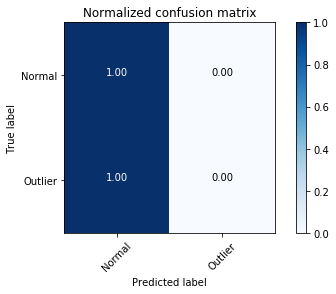

In [76]:
evaluation_summary(y_true, predictions_classes, plot_cm=True)

## Sklearn OCSVM

In [92]:
sklearn_predictions.shape == y_true.shape, sklearn_predictions.shape, y_true.shape

(True, (300,), (300,))

Normalized confusion matrix
[[0.88666667 0.11333333]
 [0.64       0.36      ]]


Accuracy     0.623333
Precision    0.760563
Recall       0.360000
f1-score     0.488688
dtype: float64

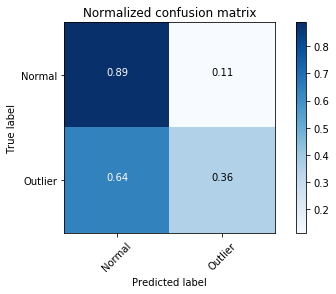

In [93]:
evaluation_summary(y_true, sklearn_predictions, plot_cm=True)

* La précision est forte, les prédits anormaux sont souvent bien des anormaux (ceux avec défaut, valeur à 1)
* La recall est faible, les cas anormaux ne sont pas souvent détectés
* L'accuracy est forte, mais en regardant la matrice de confusion on a tendance a toujours dire normal (ce qui confirme le faible recall)